In [1]:
import poliastro as PA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time as time_pkg

from astropy import units as u

from poliastro.bodies import Earth, Body
from poliastro.twobody import Orbit
from poliastro.examples import iss

from scipy.stats import expon, uniform, norm, triang
from scipy.special import comb

from lib.GPUKeplerSimulation import propagate, average_scaler, average_3vector
from lib.DisplaySimulation import displaySimulation
from lib.PopulateDistribution import nearSHODistribution, beerCanSHODistribution

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


In [69]:
size = 20000
r_0 = 0.05*u.km
epsilon = 0.0000001*u.kg*u.km**2/u.s
k = 0.0001*u.kg*u.km**3/u.s**2
m = 0.1*u.kg
J_1, J_2, J_3, M, w, Omega = beerCanSHODistribution(size, r_0, epsilon, k, m)

In [38]:
omega = np.sqrt(k/m)/np.power(r_0, 3.0/2.0)
omega_prime = -3/(2*m*np.power(r_0, 2.0))
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Linear period: ", 2*np.pi/omega)
print("Decoherence Time: ", 2*np.pi/(omega_prime*epsilon))

# average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
# print("Initial average radius: ", average_radius)

Omega_0:  2.8284271247461894 1 / s
Omega_prime:  -5999.999999999998 1 / (kg km2)
Linear period:  2.2214414690791835 s
Decoherence Time:  -10471.97551196598 s


In [70]:
a = np.square(J_1)
ecc = np.sqrt(1 - np.square(J_2/J_1)) * u.one
inc = np.arccos(J_3/J_2)

GM = Body(None, k/m, "Central Body")

In [40]:
class AsteroidBelt:
    size = 0
    micro = 1*u.km**3/u.s**2
    a = np.array([])*u.km
    ecc = np.array([])*u.one
    inc = np.array([])*u.rad
    Omega = np.array([])*u.rad
    w = np.array([])*u.rad
    M = np.array([])*u.rad
    def __init__(self, _size, _micro, _a, _ecc, _inc, _Omega, _w, _M):
        self.size = _size
        self.micro = _micro
        self.a = _a
        self.ecc = _ecc
        self.inc = _inc
        self.Omega = _Omega
        self.w = _w
        self.M = _M

In [71]:
belt = AsteroidBelt(size, k/m, a, ecc, inc, Omega, w, M)

In [72]:
timestep = 11*u.second

time_before_kick = 200*u.second
time_after_kick = 2200*u.second
time_after_quad_kick = 10000*u.second

dipole_time = time_before_kick
quad_time = time_before_kick + time_after_kick
end_time = time_before_kick + time_after_kick + time_after_quad_kick

dipole_step = int(dipole_time/timestep)
quad_step = int(quad_time/timestep)
end_step = int(end_time/timestep)


time = np.linspace(0.0*u.second, end_time, end_step)

avr_radius = np.zeros(end_step) * u.km

radiuses = np.zeros((size, end_step)) * u.km
velocities = np.zeros((size, end_step)) * u.km/u.s

In [73]:

radiuses[:,0:dipole_step], velocities[:,0:dipole_step], final_mean_anamoly = propagate(belt, dipole_time, timestep)
belt.M = final_mean_anamoly

In [74]:
avr_radius[0:dipole_step] = average_scaler(radiuses, end=dipole_step)

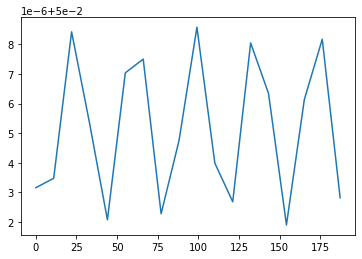

In [75]:
plt.plot(time[0:dipole_step], avr_radius[0:dipole_step])
plt.show()

In [76]:
unit_r = np.empty(3) 
newR = np.empty(3)

orb = [None]*belt.size

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

kickStrength = 0.001*u.km

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        old_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        newPosition = orb[i].r + kickStrength*unit_r
        oldThetaVelocity = orb[i].v - np.dot(orb[i].v, unit_r)*unit_r
        newThetaVelocity = old_radius/(old_radius + kickStrength)*oldThetaVelocity
        newVelocity = np.dot(orb[i].v, unit_r)*unit_r + newThetaVelocity
        orb[i] = Orbit.from_vectors(GM, newPosition, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        new_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        if old_r_0 - new_r_0 > 10**-12*u.km:
            print("L_2 before and after do not match: ", old_r_0, "\t", new_r_0)
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
        if (orb[i].r != newPosition).any():
            print("r got missassigned.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [77]:
radiuses[:,dipole_step:quad_step], velocities[:,dipole_step:quad_step], final_mean_anamoly = propagate(belt, (quad_step-dipole_step)*timestep, timestep)
belt.M = final_mean_anamoly

In [78]:
avr_radius[dipole_step:quad_step] = average_scaler(radiuses, start=dipole_step, end=quad_step)

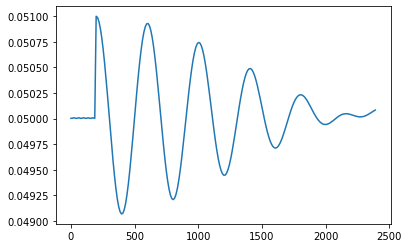

In [79]:
plt.plot(time[0:quad_step], avr_radius[0:quad_step])

In [80]:
unit_r = np.empty(3) 
newR = np.empty(3)

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

quad_strength = 0.10 * u.second**-1
radius_offset = r_0

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        newVelocity = orb[i].v + quad_strength*(old_radius - radius_offset)*unit_r
        orb[i] = Orbit.from_vectors(GM, orb[i].r, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [81]:
radiuses[:,quad_step:end_step], velocities[:,quad_step:end_step], final_mean_anamoly = propagate(belt, (end_step - quad_step)*timestep, timestep)
belt.M = final_mean_anamoly

In [82]:
avr_radius[quad_step:end_step] = average_scaler(radiuses, start=quad_step, end=end_step)

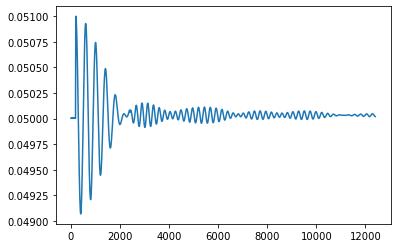

In [83]:
plt.plot(time[0:end_step], avr_radius[0:end_step])